# 使用条件对抗网络的图像到图像转换—Pix2Pix

## Pix2Pix概述

Pix2Pix是基于条件生成对抗网络（cGAN, Condition Generative Adversarial Networks ）实现的一种深度学习图像转换模型，该模型是由Phillip Isola等作者在2017年CVPR上提出的,可以实现语义/标签到真实图片、灰度图到彩色图、航空图到地图、白天到黑夜、线稿图到实物图的转换。Pix2Pix是将cGAN应用于有监督的图像到图像翻译的经典之作，其包括两个模型：**生成器**和**判别器**。

传统上，尽管此类任务的目标都是相同的从像素预测像素，但每项都是用单独的专用机器来处理的。而Pix2Pix使用的网络作为一个通用框架，使用相同的架构和目标，只在不同的数据上进行训练，即可得到令人满意的结果，鉴于此许多人已经使用此网络发布了他们自己的艺术作品。

## 基础原理

cGAN的生成器与传统GAN的生成器在原理上有一些区别，cGAN的生成器是将输入图片作为指导信息，由输入图像不断尝试生成用于迷惑判别器的“假”图像，由输入图像转换输出为相应“假”图像的本质是从像素到另一个像素的映射，而传统GAN的生成器是基于一个给定的随机噪声生成图像，输出图像通过其他约束条件控制生成，这是cGAN和GAN的在图像翻译任务中的差异。Pix2Pix中判别器的任务是判断从生成器输出的图像是真实的训练图像还是生成的“假”图像。在生成器与判别器的不断博弈过程中，模型会达到一个平衡点，生成器输出的图像与真实训练数据使得判别器刚好具有50%的概率判断正确。

在教程开始前，首先定义一些在整个过程中需要用到的符号：

- $x$：代表观测图像的数据。
- $z$：代表随机噪声的数据。
- $y=G(x,z)$：生成器网络，给出由观测图像$x$与随机噪声$z$生成的“假”图片，其中$x$来自于训练数据而非生成器。
- $D(x,G(x,z))$：判别器网络，给出图像判定为真实图像的概率，其中$x$来自于训练数据，$G(x,z)$来自于生成器。

cGAN的目标可以表示为：

$$L_{cGAN}(G,D)=E_{(x,y)}[log(D(x,y))]+E_{(x,z)}[log(1-D(x,G(x,z)))]$$

该公式是cGAN的损失函数，`D`想要尽最大努力去正确分类真实图像与“假”图像，也就是使参数$log D(x,y)$最大化；而`G`则尽最大努力用生成的“假”图像$y$欺骗`D`，避免被识破，也就是使参数$log(1−D(G(x,z)))$最小化。cGAN的目标可简化为：

$$arg\min_{G}\max_{D}L_{cGAN}(G,D)$$

![gan.png](./images/gan.png)

为了对比cGAN和GAN的不同，我们将GAN的目标也进行了说明：

$$L_{GAN}(G,D)=E_{y}[log(D(y))]+E_{(x,z)}[log(1-D(x,z))]$$


从公式可以看出，GAN直接由随机噪声$z$生成“假”图像，不借助观测图像$x$的任何信息。过去的经验告诉我们，GAN与传统损失混合使用是有好处的，判别器的任务不变，依旧是区分真实图像与“假”图像，但是生成器的任务不仅要欺骗判别器，还要在传统损失的基础上接近训练数据。假设cGAN与L1正则化混合使用，那么有:

$$L_{L1}(G)=E_{(x,y,z)}[||y-G(x,z)||_{1}]$$

进而得到最终目标：

$$arg\min_{G}\max_{D}L_{cGAN}(G,D)+\lambda L_{L1}(G)$$

图像转换问题本质上其实就是像素到像素的映射问题，Pix2Pix使用完全一样的网络结构和目标函数，仅更换不同的训练数据集就能分别实现以上的任务。本任务将借助MindSpore框架来实现Pix2Pix的应用。

## 准备环节

### 配置环境文件

本教程我们在GPU环境下，使用图模式运行实验。

In [1]:
from mindspore import context

#选择执行模式为图模式；指定训练使用的平台为"GPU"，如需使用昇腾硬件可将其替换为"Ascend"
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

### 准备数据

在本教程中，我们将使用[指定数据集](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)，该数据集为六种数据集，分别为外墙（facades）、市景（cityscapes）、地图（maps）、昼夜图（night2day）、鞋子图片及对应线条图（edges2shoes）、手包图片及对应线条图（edges2handbags）。  
每类数据集均保存于/datasets文件夹下，如/datasets/maps等，具体结构及图片数量如下

```text
 └── datasets
        └── facades
            └── train          # 400 images
            └── test           # 106 images
            └── val            # 100 images
        ├── cityscapes
            └── train          # 2975 images
            └── val            # 500 images
        ├── maps
            └── train          # 1096 images
            └── val            # 1098 images
        ├── night2day
            └── train          # 17823 images
            └── test           # 2287 images
            └── val            # 10 images
        ├── edges2shoes
            └── train          # 49825 images
            └── val            # 200 images
        └── edges2handbags
            └── train          # 138567 images
            └── val            # 200 images
```

### 数据处理

以facades数据集为例，首先定义一些配置参数：

```text
train_data_dir = "/home/pix2pix/end/datasets/facades/train/"                    # 训练集的文件路径
epoch_num = 200                                                                 # 训练迭代次数
batch_size = 1                                                                  # 训练中使用的批量大小
dataset_size = 400                                                              # 训练数据集大小
val_data_dir = "/home/pix2pix/end/datasets/facades/val/"                        # 推理数据集的文件路径
ckpt = "results/ckpt/Generator_200.ckpt"                                        # 推理用ckpt文件的文件路径
device_target = "GPU"                                                           # GPU或Ascend
# 以上参数需要根据不同数据集单独设置
```

各个数据集的训练轮次数`epoch_num`、输入图像批次`batch_size`等不同，需根据不同数据集相应设置。论文参考值展示如下：  

| 数据集及参数 | epoch_num | batch_size | dataset_size | ckpt |
| :----:| :----: | :----: | :----: | :----: |
| facades | 200 | 1 | 400 | 'results/ckpt/Generator_200.ckpt' |
| cityscapes | 200 | 1 | 2975 | 'results/ckpt/Generator_200.ckpt' |
| maps | 200 | 1 | 1096 | 'results/ckpt/Generator_200.ckpt' |
| night2day | 17 | 4 | 17823 | 'results/ckpt/Generator_17.ckpt' |
| edges2shoes | 15 | 4 | 49825 | 'results/ckpt/Generator_15.ckpt' |
| edges2handbags | 15 | 4 | 138567 | 'results/ckpt/Generator_15.ckpt' |

定义`Pix2PixDataset`和`create_train_dataset`函数对训练数据进行处理和增强操作。

In [2]:
import os
import numpy as np
from PIL import Image

import mindspore
from mindspore import dataset as ds
import mindspore.dataset.vision.c_transforms as transforms


def get_params(load_size, train_pic_size):
    """从图像中获取参数"""

    new_h = new_w = load_size

    x = np.random.randint(0, np.maximum(0, new_w - train_pic_size))
    y = np.random.randint(0, np.maximum(0, new_h - train_pic_size))

    return x, y

def crop(img, pos, load_size, train_pic_size):
    """裁剪图像"""

    ow = oh = load_size
    x1, y1 = pos
    tw = th = train_pic_size
    if ow > tw or oh > th:
        img = img.crop((x1, y1, x1 + tw, y1 + th))
        return img
    return img

def sync_random_horizontal_flip(input_images, target_images):
    """随机翻转输入图像和目标图像"""

    seed = np.random.randint(0, 2000000000)
    mindspore.set_seed(seed)
    op = transforms.RandomHorizontalFlip(prob=0.5)
    out_input = op(input_images)
    mindspore.set_seed(seed)
    op = transforms.RandomHorizontalFlip(prob=0.5)
    out_target = op(target_images)
    return out_input, out_target

class Pix2PixDataset():
    """定义训练数据集过程"""

    def __init__(self, root_dir, config):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        self.load_size = config.load_size
        self.train_pic_size = config.train_pic_size

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        ab = Image.open(img_path).convert('RGB')
        w, h = ab.size
        w2 = int(w / 2)

        a = ab.crop((w2, 0, w, h))
        b = ab.crop((0, 0, w2, h))

        a = a.resize((self.load_size, self.load_size))
        b = b.resize((self.load_size, self.load_size))

        transform_params = get_params(self.load_size, self.train_pic_size)
        a_crop = crop(a, transform_params, self.load_size, self.train_pic_size)
        b_crop = crop(b, transform_params, self.load_size, self.train_pic_size)

        return a_crop, b_crop

def create_train_dataset(dataset, batch_size):
    """创建训练集"""

    mean = [0.5 * 255] * 3
    std = [0.5 * 255] * 3

    trans = [
        transforms.Normalize(mean=mean, std=std),
        transforms.HWC2CHW()
    ]

    train_ds = ds.GeneratorDataset(dataset, column_names=["input_images", "target_images"], shuffle=False)

    train_ds = train_ds.map(operations=[sync_random_horizontal_flip], input_columns=["input_images", "target_images"])

    train_ds = train_ds.map(operations=trans, input_columns=["input_images"])
    train_ds = train_ds.map(operations=trans, input_columns=["target_images"])

    train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)

    return train_ds

调用`Pix2PixDataset`和`create_train_dataset`读取训练集，通过`create_dict_iterator`函数将数据转换成字典迭代器，然后使用`matplotlib`模块可视化部分训练数据。

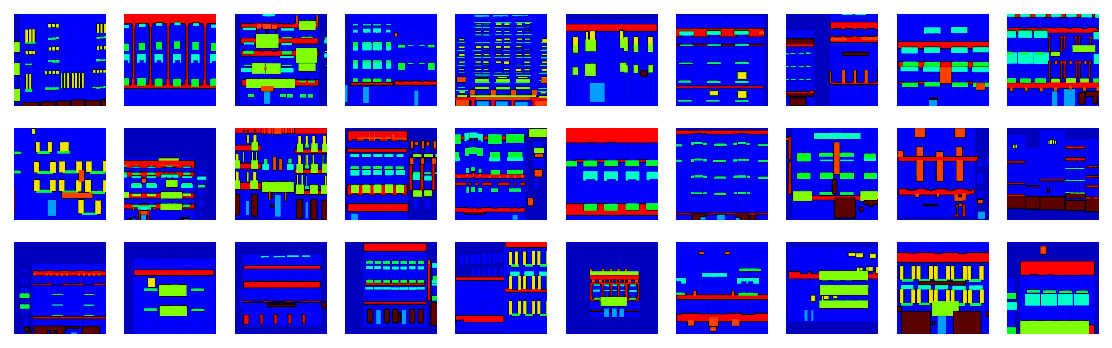

In [3]:
import matplotlib.pyplot as plt

from src.process_datasets.dataset import Pix2PixDataset, create_train_dataset
from src.config.pix2pix_config import parse_args

config = parse_args()
dataset = Pix2PixDataset(root_dir='/home/ma-user/work/fixpix2pix/datasets/facades/train/', config=config) # 以facades数据集为例
ds = create_train_dataset(dataset, batch_size=30) # 选择一批30张图片
data_iter = next(ds.create_dict_iterator(output_numpy=True))
# 可视化部分训练数据
plt.figure(figsize=(10, 3), dpi=140)
for i, image in enumerate(data_iter['input_images'][:30], 1):
    plt.subplot(3, 10, i)
    plt.axis("off")
    plt.imshow(image.transpose(1, 2, 0))
plt.show()

## 创建网络

当处理完数据后，就可以来进行网络的搭建了。网络搭建将逐一详细讨论生成器、判别器和损失函数。生成器G用到的是U-Net结构，输入的轮廓图$x$编码再解码成真是图片，判别器D用到的是作者自己提出来的条件判别器PatchGAN，判别器D的作用是在轮廓图 $x$的条件下，对于生成的图片$G(x)$判断为假，对于真实判断为真。

### 生成器G结构

U-Net是德国Freiburg大学模式识别和图像处理组提出的一种全卷积结构。它分为两个部分，其中左侧是由卷积和降采样操作组成的压缩路径，右侧是由卷积和上采样组成的扩张路径，扩张的每个网络块的输入由上一层上采样的特征和压缩路径部分的特征拼接而成。网络模型整体是一个U形的结构，因此被叫做U-Net。和常见的先降采样到低维度，再升采样到原始分辨率的编解码结构的网络相比，U-Net的区别是加入skip-connection，对应的feature maps和decode之后的同样大小的feature maps按通道拼一起，用来保留不同分辨率下像素级的细节信息。
![unet.png](./images/unet.png)


#### 定义UNet Skip Connection Block

In [4]:
import mindspore.nn as nn
import mindspore.ops as ops


class UNetSkipConnectionBlock(nn.Cell):
    """UNet子模块"""

    def __init__(self, outer_nc, inner_nc, in_planes=None, dropout=False,
                 submodule=None, outermost=False, innermost=False, alpha=0.2, norm_mode='batch'):
        super(UNetSkipConnectionBlock, self).__init__()
        downnorm = nn.BatchNorm2d(inner_nc)
        upnorm = nn.BatchNorm2d(outer_nc)
        use_bias = False
        if norm_mode == 'instance':
            downnorm = nn.BatchNorm2d(inner_nc, affine=False)
            upnorm = nn.BatchNorm2d(outer_nc, affine=False)
            use_bias = True
        if in_planes is None:
            in_planes = outer_nc
        downconv = nn.Conv2d(in_planes, inner_nc, kernel_size=4,
                             stride=2, padding=1, has_bias=use_bias, pad_mode='pad')
        downrelu = nn.LeakyReLU(alpha)
        uprelu = nn.ReLU()

        if outermost:
            upconv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, pad_mode='pad')
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.Conv2dTranspose(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, has_bias=use_bias, pad_mode='pad')
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.Conv2dTranspose(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, has_bias=use_bias, pad_mode='pad')
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            model = down + [submodule] + up
            if dropout:
                model.append(nn.Dropout(0.5))

        self.model = nn.SequentialCell(model)
        self.skip_connections = not outermost
        self.concat = ops.Concat(axis=1)

    def construct(self, x):
        out = self.model(x)
        if self.skip_connections:
            out = self.concat((out, x))
        return out

#### 基于UNet的生成器

In [5]:
import mindspore.nn as nn

from src.models.unet_block import UNetSkipConnectionBlock


class UNetGenerator(nn.Cell):
    """基于UNet的生成器"""

    def __init__(self, in_planes, out_planes, ngf=64, n_layers=8, norm_mode='bn', dropout=False):
        super(UNetGenerator, self).__init__()
        # construct unet structure
        unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=None,
                                             norm_mode=norm_mode, innermost=True)
        for _ in range(n_layers - 5):
            unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, in_planes=None, submodule=unet_block,
                                                 norm_mode=norm_mode, dropout=dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UNetSkipConnectionBlock(ngf * 4, ngf * 8, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UNetSkipConnectionBlock(ngf * 2, ngf * 4, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        unet_block = UNetSkipConnectionBlock(ngf, ngf * 2, in_planes=None, submodule=unet_block,
                                             norm_mode=norm_mode)
        self.model = UNetSkipConnectionBlock(out_planes, ngf, in_planes=in_planes, submodule=unet_block,
                                             outermost=True, norm_mode=norm_mode)

    def construct(self, x):
        return self.model(x)

原始cGAN的输入是条件x和噪声z两种信息，这里的生成器只使用了条件信息，因此不能生成多样性的结果。因此Pix2Pix在训练和测试时都使用了dropout，这样可以生成多样性的结果。

### 基于PatchGAN的判别器

判别器使用的PatchGAN结构，可看做卷积。生成的矩阵中的每个点代表原图的一小块区域（patch）。通过矩阵中的各个值来判断原图中对应每个Patch的真假。

In [6]:
import mindspore.nn as nn
from mindspore.ops import Concat


class ConvNormRelu(nn.Cell):
    """操作融合的卷积块"""

    def __init__(self,
                 in_planes,
                 out_planes,
                 config,
                 kernel_size=4,
                 stride=2,
                 alpha=0.2,
                 norm_mode='batch',
                 pad_mode='CONSTANT',
                 use_relu=True,
                 padding=None):
        super(ConvNormRelu, self).__init__()
        norm = nn.BatchNorm2d(out_planes)
        if norm_mode == 'instance':
            norm = nn.BatchNorm2d(out_planes, affine=False)
        has_bias = (norm_mode == 'instance')
        if not padding:
            padding = (kernel_size - 1) // 2
        if config.pad_mode == 'REFLECT':
            pad_mode = "REFLECT"
        elif config.pad_mode == "SYMMETRIC":
            pad_mode = "SYMMETRIC"
        if pad_mode == 'CONSTANT':
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, pad_mode='pad',
                             has_bias=has_bias, padding=padding)
            layers = [conv, norm]
        else:
            paddings = ((0, 0), (0, 0), (padding, padding), (padding, padding))
            pad = nn.Pad(paddings=paddings, mode=pad_mode)
            conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, pad_mode='pad', has_bias=has_bias)
            layers = [pad, conv, norm]
        if use_relu:
            relu = nn.ReLU()
            if alpha > 0:
                relu = nn.LeakyReLU(alpha)
            layers.append(relu)
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output

class Discriminator(nn.Cell):
    """判别器模型"""

    def __init__(self, config, in_planes=3, ndf=64, n_layers=3, alpha=0.2, norm_mode='batch'):
        super(Discriminator, self).__init__()
        kernel_size = 4
        layers = [
            nn.Conv2d(in_planes, ndf, kernel_size, 2, pad_mode='pad', padding=1),
            nn.LeakyReLU(config.alpha)
        ]
        nf_mult = ndf
        for i in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** i, 8) * ndf
            layers.append(ConvNormRelu(nf_mult_prev, nf_mult, config, kernel_size, 2, alpha, norm_mode, padding=1))
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8) * ndf
        layers.append(ConvNormRelu(nf_mult_prev, nf_mult, config, kernel_size, 1, alpha, norm_mode, padding=1))
        layers.append(nn.Conv2d(nf_mult, 1, kernel_size, 1, pad_mode='pad', padding=1))

        self.features = nn.SequentialCell(layers)
        self.concat = Concat(axis=1)

    def construct(self, x, y):
        x_y = self.concat((x, y))
        output = self.features(x_y)
        return output

### Pix2Pix的生成器和判别器初始化

实例化Pix2Pix生成器和判别器。

In [7]:
import mindspore.nn as nn
from mindspore.common import initializer as init

from src.models.generator import UNetGenerator
from src.models.discriminator import Discriminator
from src.config.pix2pix_config import parse_args

def get_generator(config):
    """通过参数返回一个生成器"""

    net_generator = UNetGenerator(in_planes=config.g_in_planes, out_planes=config.g_out_planes,
                                  ngf=config.g_ngf, n_layers=config.g_layers)
    for _, cell in net_generator.cells_and_names():
        if isinstance(cell, (nn.Conv2d, nn.Conv2dTranspose)):
            if config.init_type == 'normal':
                cell.weight.set_data(init.initializer(init.Normal(config.init_gain), cell.weight.shape))
            elif config.init_type == 'xavier':
                cell.weight.set_data(init.initializer(init.XavierUniform(config.init_gain), cell.weight.shape))
            elif config.init_type == 'constant':
                cell.weight.set_data(init.initializer(0.001, cell.weight.shape))
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % config.init_type)
        elif isinstance(cell, nn.BatchNorm2d):
            cell.gamma.set_data(init.initializer('ones', cell.gamma.shape))
            cell.beta.set_data(init.initializer('zeros', cell.beta.shape))
    return net_generator

def get_discriminator(config):
    """通过参数返回一个判别器"""

    net_discriminator = Discriminator(config, in_planes=config.d_in_planes, ndf=config.d_ndf,
                                      alpha=config.alpha, n_layers=config.d_layers)
    for _, cell in net_discriminator.cells_and_names():
        if isinstance(cell, (nn.Conv2d, nn.Conv2dTranspose)):
            if config.init_type == 'normal':
                cell.weight.set_data(init.initializer(init.Normal(config.init_gain), cell.weight.shape))
            elif config.init_type == 'xavier':
                cell.weight.set_data(init.initializer(init.XavierUniform(config.init_gain), cell.weight.shape))
            elif config.init_type == 'constant':
                cell.weight.set_data(init.initializer(0.001, cell.weight.shape))
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % config.init_type)
        elif isinstance(cell, nn.BatchNorm2d):
            cell.gamma.set_data(init.initializer('ones', cell.gamma.shape))
            cell.beta.set_data(init.initializer('zeros', cell.beta.shape))
    return net_discriminator

class Pix2Pix(nn.Cell):
    """Pix2Pix模型网络"""
    def __init__(self, discriminator, generator):
        super(Pix2Pix, self).__init__(auto_prefix=True)
        self.net_discriminator = discriminator
        self.net_generator = generator

    def construct(self, reala):
        fakeb = self.net_generator(reala)
        return fakeb

config = parse_args()
net_generator = get_generator(config)
net_discriminator = get_discriminator(config)
pix2pix = Pix2Pix(generator=net_generator, discriminator=net_discriminator)

### 连接网络和损失函数

MindSpore将损失函数、优化器等操作都封装到了Cell中，因为GAN结构上的特殊性，其损失是判别器和生成器的多输出形式，这就导致它和一般的分类网络不同。所以我们需要自定义`WithLossCell`类，将网络和Loss连接起来。

In [8]:
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.ops import functional as opsf
import mindspore.ops.operations as opsp
from mindspore.parallel._utils import (_get_device_num, _get_gradients_mean, _get_parallel_mode)
from mindspore.context import ParallelMode
from mindspore.nn.wrap.grad_reducer import DistributedGradReducer
from mindspore.nn.loss.loss import LossBase


class SigmoidCrossEntropyWithLogits(LossBase):
    """计算预测值与真实值之间的sigmoid交叉熵"""

    def __init__(self):
        super(SigmoidCrossEntropyWithLogits, self).__init__()
        self.cross_entropy = opsp.SigmoidCrossEntropyWithLogits()

    def construct(self, data, label):
        x = self.cross_entropy(data, label)
        return self.get_loss(x)

class LossD(LossBase):
    """定义鉴别器损失"""

    def __init__(self, config, reduction="mean"):
        super(LossD, self).__init__(reduction)
        self.sig = SigmoidCrossEntropyWithLogits()
        self.ones = ops.OnesLike()
        self.zeros = ops.ZerosLike()
        self.lambda_dis = config.lambda_dis

    def construct(self, pred1, pred0):
        loss = self.sig(pred1, self.ones(pred1)) + self.sig(pred0, self.zeros(pred0))
        dis_loss = loss * self.lambda_dis
        return dis_loss


class WithLossCellD(nn.Cell):
    """定义判别器损失封装连接网络"""

    def __init__(self, backbone, loss_fn):
        super(WithLossCellD, self).__init__(auto_prefix=True)
        self.net_discriminator = backbone.net_discriminator
        self.net_generator = backbone.net_generator
        self._loss_fn = loss_fn

    def construct(self, reala, realb):
        fakeb = self.net_generator(reala)
        pred1 = self.net_discriminator(reala, realb)
        pred0 = self.net_discriminator(reala, fakeb)
        return self._loss_fn(pred1, pred0)


class LossG(LossBase):
    """定义生成器损失"""

    def __init__(self, config, reduction="mean"):
        super(LossG, self).__init__(reduction)
        self.sig = SigmoidCrossEntropyWithLogits()
        self.l1_loss = nn.L1Loss()
        self.ones = ops.OnesLike()
        self.lambda_gan = config.lambda_gan
        self.lambda_l1 = config.lambda_l1

    def construct(self, fakeb, realb, pred0):
        loss_1 = self.sig(pred0, self.ones(pred0))
        loss_2 = self.l1_loss(fakeb, realb)
        loss = loss_1 * self.lambda_gan + loss_2 * self.lambda_l1
        return loss


class WithLossCellG(nn.Cell):
    """定义生成器损失封装连接网络"""

    def __init__(self, backbone, loss_fn):
        super(WithLossCellG, self).__init__(auto_prefix=True)
        self.net_discriminator = backbone.net_discriminator
        self.net_generator = backbone.net_generator
        self._loss_fn = loss_fn

    def construct(self, reala, realb):
        fakeb = self.net_generator(reala)
        pred0 = self.net_discriminator(reala, fakeb)
        return self._loss_fn(fakeb, realb, pred0)


class TrainOneStepCell(nn.Cell):
    """定义训练网络封装类"""

    def __init__(self, loss_netd, loss_netg, optimizerd, optimizerg, sens=1, auto_prefix=True):
        super(TrainOneStepCell, self).__init__(auto_prefix=auto_prefix)
        self.loss_net_d = loss_netd
        self.loss_net_d.set_grad()
        self.loss_net_d.add_flags(defer_inline=True)

        self.loss_net_g = loss_netg
        self.loss_net_g.set_grad()
        self.loss_net_g.add_flags(defer_inline=True)

        self.weights_g = optimizerg.parameters
        self.optimizerg = optimizerg
        self.weights_d = optimizerd.parameters
        self.optimizerd = optimizerd

        self.grad = ops.GradOperation(get_by_list=True, sens_param=True)
        self.sens = sens

        # 并行处理
        self.reducer_flag = False
        self.grad_reducer_g = opsf.identity
        self.grad_reducer_d = opsf.identity
        self.parallel_mode = _get_parallel_mode()
        if self.parallel_mode in (ParallelMode.DATA_PARALLEL, ParallelMode.HYBRID_PARALLEL):
            self.reducer_flag = True
        if self.reducer_flag:
            mean = _get_gradients_mean()
            degree = _get_device_num()
            self.grad_reducer_g = DistributedGradReducer(self.weights_g, mean, degree)
            self.grad_reducer_d = DistributedGradReducer(self.weights_d, mean, degree)

    def set_sens(self, value):
        self.sens = value

    def construct(self, reala, realb):
        d_loss = self.loss_net_d(reala, realb)
        g_loss = self.loss_net_g(reala, realb)
        d_sens = ops.Fill()(ops.DType()(d_loss), ops.Shape()(d_loss), self.sens)
        d_grads = self.grad(self.loss_net_d, self.weights_d)(reala, realb, d_sens)
        d_res = ops.depend(d_loss, self.optimizerd(d_grads))
        g_sens = ops.Fill()(ops.DType()(g_loss), ops.Shape()(g_loss), self.sens)
        g_grads = self.grad(self.loss_net_g, self.weights_g)(reala, realb, g_sens)
        g_res = ops.depend(g_loss, self.optimizerg(g_grads))
        return d_res, g_res

## 训练

训练分为两个主要部分：训练判别器和训练生成器。训练判别器的目的是最大程度地提高判别图像真伪的概率。训练生成器是希望能产生更好的虚假图像。在这两个部分中，分别获取训练过程中的损失，并在每个周期结束时进行统计。

下面进行训练：

### 训练过程

In [9]:
# 导入各模块
import os
import datetime

import mindspore.nn as nn
from mindspore import context
from mindspore import Tensor
from mindspore.train.serialization import save_checkpoint

from src.models.loss import WithLossCellD, LossD, WithLossCellG, LossG, TrainOneStepCell
from src.models.pix2pix import Pix2Pix, get_generator, get_discriminator
from src.process_datasets.dataset import Pix2PixDataset, create_train_dataset
from src.utils.tools import get_lr
from src.config.pix2pix_config import parse_args

# 配置信息
arg = parse_args()
context.set_context(mode=context.GRAPH_MODE)

# 预处理数据以进行训练
dataset = Pix2PixDataset(root_dir=arg.train_data_dir, config=arg)
ds = create_train_dataset(dataset, batch_size=arg.batch_size)
steps_per_epoch = ds.get_dataset_size()
print("ds:", ds.get_dataset_size())
print("ds:", ds.get_col_names())
print("ds.shape:", ds.output_shapes())

# 网络
net_generator = get_generator(arg)
net_discriminator = get_discriminator(arg)
pix2pix = Pix2Pix(generator=net_generator, discriminator=net_discriminator)

# 损失
d_loss_fn = LossD(arg)
g_loss_fn = LossG(arg)
d_loss_net = WithLossCellD(backbone=pix2pix, loss_fn=d_loss_fn)
g_loss_net = WithLossCellG(backbone=pix2pix, loss_fn=g_loss_fn)

# 优化器
d_opt = nn.Adam(pix2pix.net_discriminator.trainable_params(), learning_rate=get_lr(arg),
                beta1=arg.beta1, beta2=arg.beta2, loss_scale=1)
g_opt = nn.Adam(pix2pix.net_generator.trainable_params(), learning_rate=get_lr(arg),
                beta1=arg.beta1, beta2=arg.beta2, loss_scale=1)

# 训练网络
train_net = TrainOneStepCell(loss_netd=d_loss_net, loss_netg=g_loss_net, optimizerd=d_opt, optimizerg=g_opt, sens=1)
train_net.set_train()

# 迭代训练
if not os.path.isdir(arg.ckpt_dir):
    os.makedirs(arg.ckpt_dir)
g_losses = []
d_losses = []
data_loader = ds.create_dict_iterator(output_numpy=True, num_epochs=arg.epoch_num)
for epoch in range(arg.epoch_num):
    for i, data in enumerate(data_loader):
        start_time = datetime.datetime.now()
        input_image = Tensor(data["input_images"])
        target_image = Tensor(data["target_images"])
        dis_loss, gen_loss = train_net(input_image, target_image)
        end_time = datetime.datetime.now()
        delta = (end_time - start_time).microseconds
        if i % 100 == 0:
            print("ms per step :", delta / 1000, "epoch: ",
                  epoch + 1, "/", arg.epoch_num, "step: ",
                  i, "/", steps_per_epoch, "Dloss: ", dis_loss, "Gloss: ", gen_loss)

        d_losses.append(dis_loss.asnumpy())
        g_losses.append(gen_loss.asnumpy())
    if (epoch + 1) == arg.epoch_num:
        save_checkpoint(net_generator, os.path.join(arg.ckpt_dir, "Generator_200.ckpt"))

ms per step : 303.029 epoch:  1 / 200 step:  0 / 400 Dloss:  0.8002198 Gloss:  43.7544
ms per step : 11.719 epoch:  1 / 200 step:  100 / 400 Dloss:  0.33992124 Gloss:  39.517014
ms per step : 11.878 epoch:  1 / 200 step:  200 / 400 Dloss:  0.04942063 Gloss:  46.223316
ms per step : 10.457 epoch:  1 / 200 step:  300 / 400 Dloss:  0.019174982 Gloss:  42.203327
···
ms per step : 13.259 epoch:  200 / 200 step:  300 / 400 Dloss:  0.11122214 Gloss:  20.246107


循环训练网络，每次迭代，就收集生成器和判别器的损失，以便于后面绘制训练过程中损失函数的图像。

## 结果展示

定义描绘损失函数与训练迭代的关系以及生成器生成图片函数：

In [10]:
import numpy as np
from PIL import Image as image
import matplotlib.pyplot as plt
from mindspore import Tensor


def save_losses(g_losses, f_losses, idx, config):
    """绘制迭代的损失信息并保存"""

    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(g_losses, label="G")
    plt.plot(f_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Losses")
    plt.legend()
    plt.savefig(config.loss_show_dir + "/{}.png".format(idx))


def save_image(img, img_path):
    """图像保存"""

    if isinstance(img, Tensor):
        img = decode_image(img)
    elif not isinstance(img, np.ndarray):
        raise ValueError("img should be Tensor or numpy array, but get {}".format(type(img)))

    img_pil = image.fromarray(img)
    img_pil.save(img_path + ".jpg")

训练时同时调用函数以保存产生图片至指定文件，如：

```text
save_image(fake_image, config.train_fakeimg_dir + str(epoch + 1))
save_losses(g_losses, d_losses, epoch + 1)
```

![loss.png](./images/loss.png)


展示随着迭代轮次增大，各数据集不同轮次的推理图片效果

![results.gif](./images/results.gif)

从上面的图像可以看出，随着训练次数的增多，图像质量也越来越好。如当num_epochs达到论文参考值时，生成的转化图片较为合理，下面我们通过加载生成器网络模型参数文件ckpt来生成图像，代码如下

In [11]:
from mindspore.train.serialization import load_checkpoint
from mindspore.train.serialization import load_param_into_net

from src.process_datasets.dataset import create_val_dataset, Pix2PixDatasetVal
from src.config.pix2pix_config import parse_args

config = parse_args()
dataset_val = Pix2PixDatasetVal(root_dir=config.val_data_dir)
ds_val = create_val_dataset(dataset_val, config.val_pic_size)

ckpt_url = config.ckpt
param_g = load_checkpoint(ckpt_url)
load_param_into_net(net_generator, param_g)
data_loader_val = ds_val.create_dict_iterator(output_numpy=True, num_epochs=config.epoch_num)
for i, data in enumerate(data_loader_val):
    input_image = Tensor(data["input_images"])
    fake_image = net_generator(input_image)

各数据集分别推理的效果如下

![compare.png](./images/compare.png)


## 引用

[1] Phillip Isola,Jun-Yan Zhu,Tinghui Zhou,Alexei A. Efros. Image-to-Image Translation with Conditional Adversarial Networks.[J]. CoRR,2016,abs/1611.07004.